In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as stats
from scipy.stats import poisson

In [30]:
#@title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [31]:
# @title Plotting Functions

def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()

  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None:
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None

  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)

def plot_neuron_stats(v, spike_times):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

  # membrane voltage trace
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='red')

  # ISI distribution
  if len(spike_times)>1:
    isi = np.diff(spike_times)
    n_bins = np.arange(isi.min(), isi.max() + 2) - .5
    counts, bins = np.histogram(isi, n_bins)
    vlines = []
    if len(isi) > 0:
      vlines = [np.mean(isi)]
    xmax = max(20, int(bins[-1])+5)
    histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
      'xlabel': 'Inter-spike interval',
      'ylabel': 'Number of intervals',
      'xlim': [0, xmax]
    })
  else:
    ax2.set(xlabel='Inter-spike interval',
           ylabel='Number of intervals')
  plt.show()

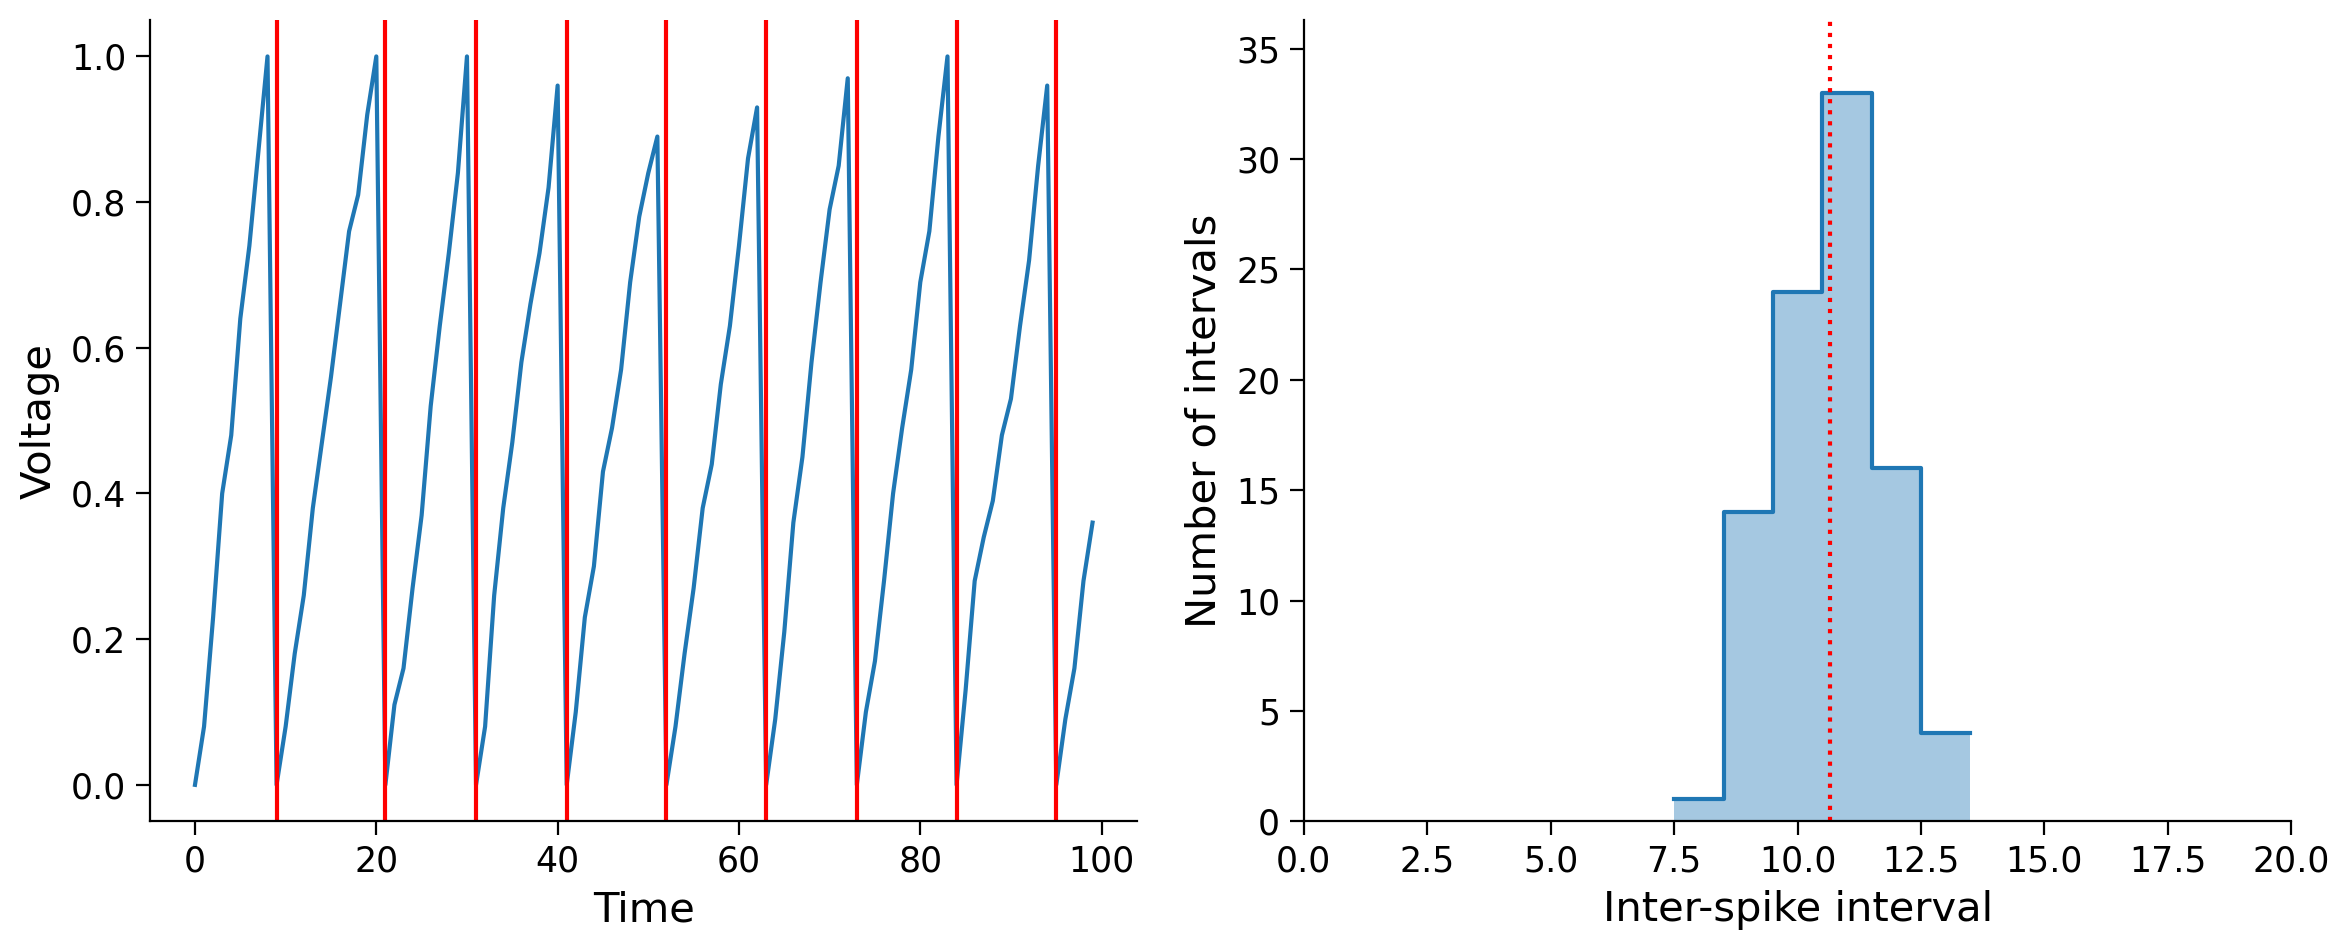

In [37]:
def lif_neuron(n_steps =1000, alpha=0.01, rate=10):
    """ Simulate a linear integrate-and-fire neuron.

    Args:
        n_steps (int): The number of time steps to simulate the neuron's activity.
        alpha (float): The input scaling factor
        rate (int): The mean rate of incoming spikes

    """
    exc = poisson(rate).rvs(n_steps)
    
    v = np.zeros(n_steps)
    spike_times = []

    for i in range(1,n_steps):
        dv = alpha * exc[i]
        v[i] = v[i-1] + dv

        if v[i] > 1:
            spike_times.append(i)
            v[i] = 0

    return v, spike_times

np.random.seed(12)

v, spike_times = lif_neuron()

plot_neuron_stats(v, spike_times)
         

In [39]:
# @markdown You don't need to worry about how the code works – but you do need to **run the cell** to enable the sliders.

def _lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  exc = poisson(rate).rvs(n_steps)
  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0
  return v, spike_times

@widgets.interact(
  alpha=widgets.FloatLogSlider(0.01, min=-2, max=-1),
  rate=widgets.IntSlider(10, min=5, max=20)
)
def plot_lif_neuron(alpha=0.01, rate=10):
  v, spike_times = _lif_neuron(2000, alpha, rate)

  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.01, description='alpha', max=-1.0, min=-2.0), IntSlider(value=10,…

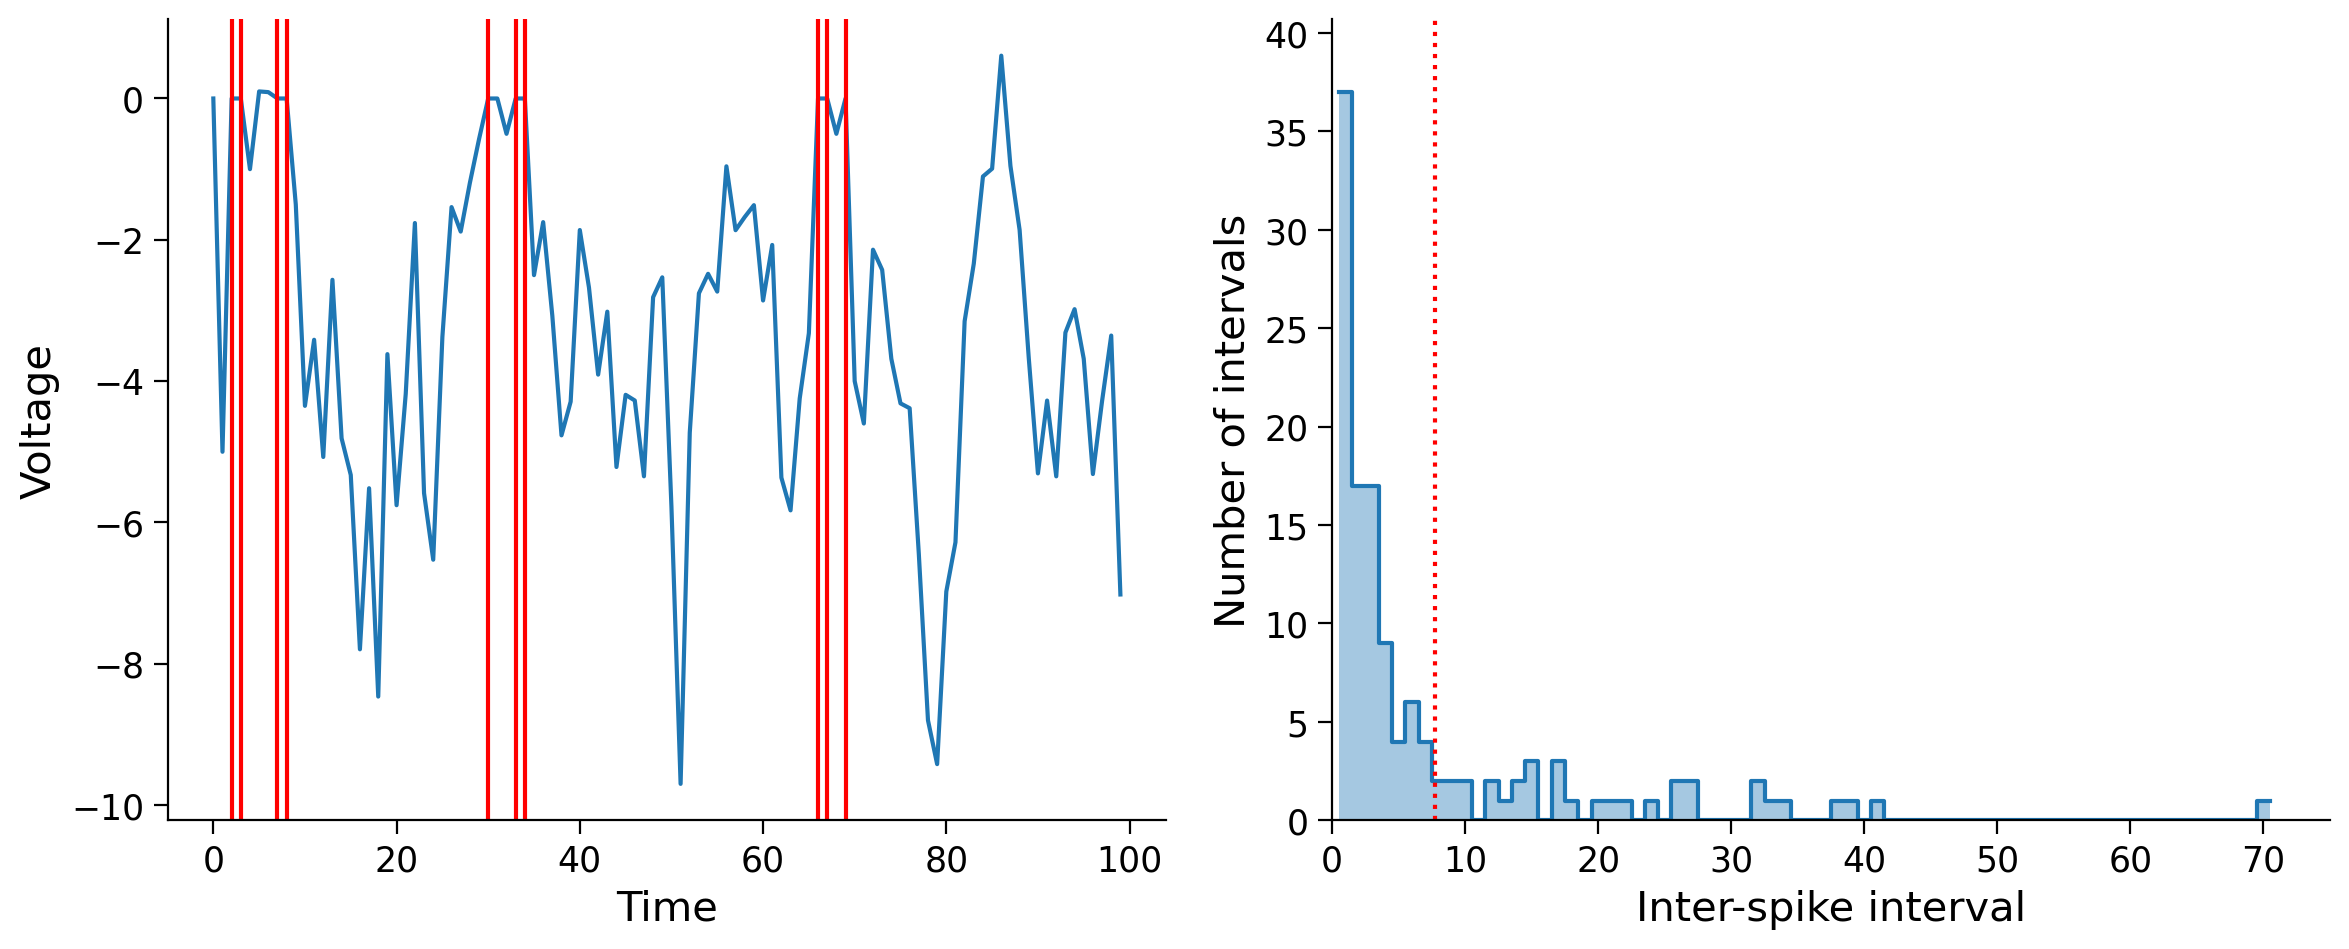

In [48]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta = 0.1, exc_rate=10, inh_rate=10):
    """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
    and inhibitory inputs.

    Args:
        n_steps (int): The number of time steps to simulate the neuron's activity.
        alpha (float): The input scaling factor
        beta (float): The membrane potential leakage factor
        exc_rate (int): The mean rate of the incoming excitatory spikes
        inh_rate (int): The mean rate of the incoming inhibitory spikes
    """
    
    exc = poisson(exc_rate).rvs(n_steps)
    inh = poisson(inh_rate).rvs(n_steps)

    v = np.zeros(n_steps)
    spike_times = []

    for i in range(1, n_steps):
        dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])

        v[i] = v[i-1] + dv
        if v[i] > 1:
            spike_times.append(i)
            v[i] = 0

    return v, spike_times

np.random.seed(12)
v,spike_times = lif_neuron_inh()

plot_neuron_stats(v,spike_times)


In [50]:
#@title
#@markdown **Run the cell** to enable the sliders.
def _lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """
  # precompute Poisson samples for speed
  exc = poisson(exc_rate).rvs(n_steps)
  inh = poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

@widgets.interact(alpha=widgets.FloatLogSlider(0.5, min=-1, max=1),
                  beta=widgets.FloatLogSlider(0.1, min=-1, max=0),
                  exc_rate=widgets.IntSlider(12, min=10, max=20),
                  inh_rate=widgets.IntSlider(12, min=10, max=20))
def plot_lif_neuron(alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  v, spike_times = _lif_neuron_inh(2000, alpha, beta, exc_rate, inh_rate)
  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.5, description='alpha', max=1.0, min=-1.0), FloatLogSlider(value=…